In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')
SEED = 1234

/home/strike/work/penv/deep/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/strike/work/penv/deep/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [2]:
train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred
    


/home/strike/work/penv/deep/lib/python3.10/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (critic): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [4]:
LEARNING_RATE = 0.01

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)
def train(env, policy, optimizer, discount_factor):
    
    policy.train()
    
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)
        
        action_pred, value_pred = policy(state)
            
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
        
    returns = calculate_returns(rewards, discount_factor)
    
    policy_loss, value_loss = update_policy(returns, log_prob_actions, values, optimizer)

    return policy_loss, value_loss, episode_reward


In [5]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r +  R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [7]:
def update_policy(returns, log_prob_actions, values, optimizer):

    returns = returns.detach()
    
    policy_loss = - (returns * log_prob_actions).sum()
    
    value_loss = F.smooth_l1_loss(returns, values).sum()
    
    optimizer.zero_grad()
    
    policy_loss.backward()
    value_loss.backward()
    
    optimizer.step()
    
    return policy_loss.item(), value_loss.item()

In [8]:
def evaluate(env, policy):
    
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
        
            action_pred, _ = policy(state)
        
            action_prob = F.softmax(action_pred, dim = -1)
                
        action = torch.argmax(action_prob, dim = -1)
                
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [9]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, critic_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR)
    
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

| Episode:  10 | Mean Train Rewards:  33.7 | Mean Test Rewards:  62.4 |
| Episode:  20 | Mean Train Rewards:  34.8 | Mean Test Rewards:  87.5 |
| Episode:  30 | Mean Train Rewards:  47.0 | Mean Test Rewards: 189.1 |
| Episode:  40 | Mean Train Rewards:  82.8 | Mean Test Rewards: 229.1 |
| Episode:  50 | Mean Train Rewards:  98.0 | Mean Test Rewards: 250.6 |
| Episode:  60 | Mean Train Rewards:  81.2 | Mean Test Rewards: 139.1 |
| Episode:  70 | Mean Train Rewards:  52.2 | Mean Test Rewards:  73.1 |
| Episode:  80 | Mean Train Rewards:  44.7 | Mean Test Rewards:  48.2 |
| Episode:  90 | Mean Train Rewards:  50.6 | Mean Test Rewards:  53.8 |
| Episode: 100 | Mean Train Rewards:  64.7 | Mean Test Rewards: 112.4 |
| Episode: 110 | Mean Train Rewards:  74.0 | Mean Test Rewards: 207.0 |
| Episode: 120 | Mean Train Rewards:  93.1 | Mean Test Rewards: 300.0 |
| Episode: 130 | Mean Train Rewards: 132.6 | Mean Test Rewards: 330.4 |
| Episode: 140 | Mean Train Rewards: 166.4 | Mean Test Rewards: 

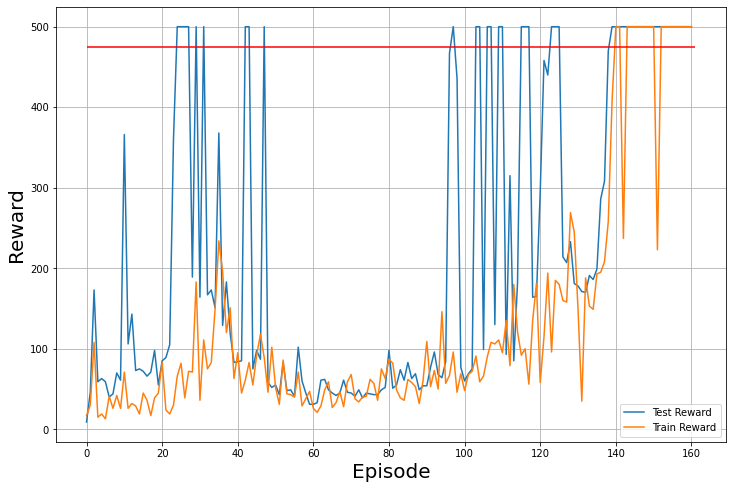

In [10]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()